In [1]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
####20 final

In [12]:
import os
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Constants
LEARNING_RATE = 0.001
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
NUM_EPOCHS = 20

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset_root = '/content/drive/MyDrive/cv'
image_datasets = datasets.ImageFolder(root=dataset_root, transform=data_transforms)

# Split the dataset
train_data, test_data = train_test_split(image_datasets, test_size=0.2, stratify=image_datasets.targets)
train_data, val_data = train_test_split(train_data, test_size=0.25, stratify=[target for _, target in train_data])

# Data loaders
train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=TEST_BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE)

# Initialize the Vision Transformer model
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(image_datasets.classes))
model = model.to(DEVICE)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# Arrays to store metrics for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [13]:
# Training loop
best_val_acc = 0.0
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()

    validation_accuracy = val_correct / len(val_loader.dataset)
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(validation_accuracy)

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}] Training Loss: {train_loss}, Training Accuracy: {train_accuracy}, Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {validation_accuracy}")

    if validation_accuracy > best_val_acc:
        best_val_acc = validation_accuracy
        torch.save(model.state_dict(), "best_vit_model.pth")

    scheduler.step()


Epoch [1/20] Training Loss: 0.8081420784509634, Training Accuracy: 0.7227290757635859, Validation Loss: 0.510838164223565, Validation Accuracy: 0.7538644470868014
Epoch [2/20] Training Loss: 0.5224041063574296, Training Accuracy: 0.7504958349861166, Validation Loss: 0.48009918685312625, Validation Accuracy: 0.7681331747919143
Epoch [3/20] Training Loss: 0.4764636309841011, Training Accuracy: 0.7786592621975407, Validation Loss: 0.44021677253422914, Validation Accuracy: 0.7966706302021404
Epoch [4/20] Training Loss: 0.46350176462644266, Training Accuracy: 0.7901626338754463, Validation Loss: 0.5452541250873495, Validation Accuracy: 0.6908442330558858
Epoch [5/20] Training Loss: 0.44415817192838164, Training Accuracy: 0.7976993256644189, Validation Loss: 0.5218745585944917, Validation Accuracy: 0.7669441141498217
Epoch [6/20] Training Loss: 0.43028070485290093, Training Accuracy: 0.8084093613645379, Validation Loss: 0.4113129824399948, Validation Accuracy: 0.807372175980975
Epoch [7/20] 

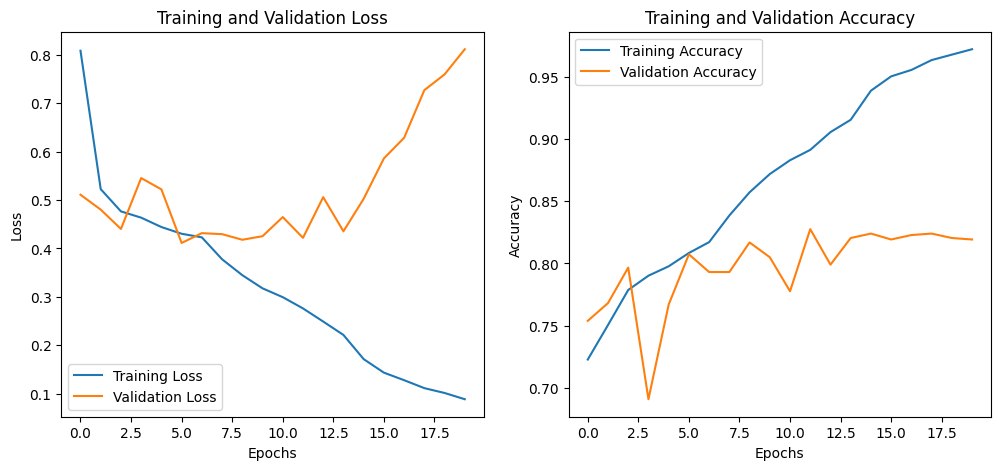

In [14]:
# Plot training and validation losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Test Accuracy: 0.8252080856123662, Precision: 0.8257475327736044, Recall: 0.8251838027372469, F1 Score: 0.8251279780807037


<ipython-input-15-9fa2565eb065>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(image_datasets.classes))
<ipython-input-15-9fa2565eb065>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(image_datasets.classes))


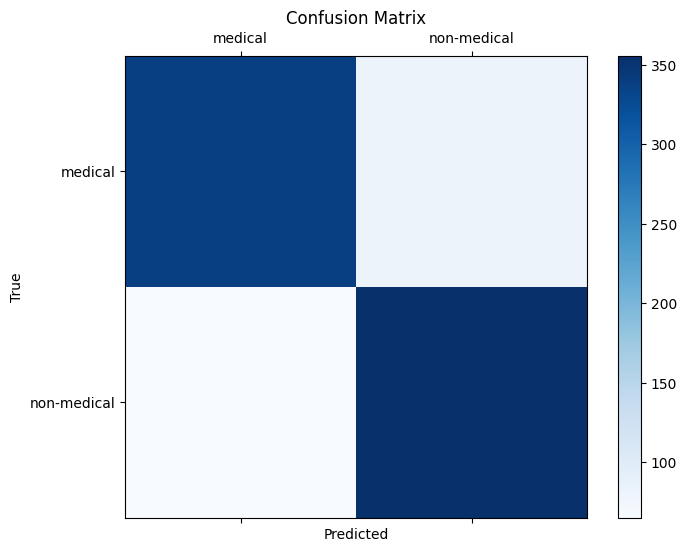

In [15]:
# Load the best model
model.load_state_dict(torch.load("best_vit_model.pth"))

# Test loop
model.eval()
true_labels, pred_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Test metrics
test_accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')
print(f"Test Accuracy: {test_accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + list(image_datasets.classes))
ax.set_yticklabels([''] + list(image_datasets.classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()